## Import libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from    datetime import datetime
from    datetime import timedelta
import  time

In [4]:
import psutil
import os, io
import sys
import platform
import sysconfig
import sklearn
import time
from   tabulate import tabulate
from   platform import python_version
import numpy             as np
import pandas            as pd
pd.set_option('display.max_rows', None)

### Why GLM- TweedieRegressor is used?
When the key assumptions of linear regression—like normality of residuals, constant variance (homoscedasticity), and independence—are violated, Generalized Linear Models (GLMs) like TweedieRegressor offer a much-needed escape hatch.

The TweedieRegressor is part of the GLM family, which extends linear models to allow:
- ✅ Non-normal distributions: Supports distributions in the exponential family, including Poisson, gamma, and compound Poisson–gamma (i.e., Tweedie).
- ✅ Variance that grows with the mean: Useful when heteroscedasticity is present.
- ✅ Flexibility in modeling skewed or zero-inflated data: Ideal for cases like insurance claims, energy usage, or used car prices with many low and few high values.


In [5]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.2 MB/s eta 0:00:00


In [6]:
import matplotlib.pyplot  as plt
import seaborn            as sns
import time

from sklearn.model_selection                 import KFold
from sklearn.metrics                         import mean_squared_error, explained_variance_score
from sklearn.ensemble                        import RandomForestRegressor
from sklearn.tree                            import DecisionTreeRegressor
from sklearn.neighbors                       import KNeighborsRegressor
from sklearn.linear_model                    import TweedieRegressor
from xgboost                                 import XGBRegressor
from catboost                                import CatBoostRegressor
from lightgbm                                import LGBMRegressor


In [7]:
def compare_models(X, y, d1, d2, d3, d4, d5, d6):
    # Define models
    models = {
        'Random Forest': RandomForestRegressor(**d1),
        'XGBoost': XGBRegressor(**d2),
        'CatBoost': CatBoostRegressor(**d3),
        'LightGBM': LGBMRegressor(**d4),
        'KNN': KNeighborsRegressor(**d5),
        'Decision Tree': DecisionTreeRegressor(**d6),
        # 'GLM (Tweedie)': TweedieRegressor()
    }

    # Cross-validation setup
    kf              = KFold(n_splits = 10, shuffle = True, random_state = 42)
    rmse_results    = {}
    evs_results     = {}
    timings         = {}

    for name, model in models.items():
        rmse_folds = []
        evs_folds = []
        start = time.time()

        for train_idx, test_idx in kf.split(X):
            model.fit(X.iloc[train_idx], y.iloc[train_idx])
            preds = model.predict(X.iloc[test_idx])
            rmse = np.sqrt(mean_squared_error(y.iloc[test_idx], preds))
            evs = explained_variance_score(y.iloc[test_idx], preds)
            rmse_folds.append(rmse)
            evs_folds.append(evs)

        end = time.time()
        rmse_results[name] = rmse_folds
        evs_results[name] = evs_folds
        timings[name] = end - start

    #  Boxplot RMSE
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=pd.DataFrame(rmse_results))
    plt.title("RMSE Across 10 Folds")
    plt.ylabel("RMSE")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    #  Boxplot Explained Variance
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=pd.DataFrame(evs_results))
    plt.title("Explained Variance Score Across 10 Folds")
    plt.ylabel("Explained Variance")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    #  Summary table
    summary = []
    for name in models:
        summary.append({
            'Model': name,
            'Mean RMSE': np.mean(rmse_results[name]),
            'Std RMSE': np.std(rmse_results[name]),
            'Mean Explained Var': np.mean(evs_results[name]),
            'Std Explained Var': np.std(evs_results[name]),
            'Time Taken (s)': timings[name]
        })

    summary_df = pd.DataFrame(summary)
    print("\n Model Performance Summary:")
    print(summary_df.round(4))

In [38]:
'''
Feature Importance: The feature_importances_ attribute provides the importance scores for each feature.
Visualization: A horizontal bar chart is plotted using matplotlib to display the importance of each feature.
'''
def  feature_plot(model, model_txt, X, features):
    import  matplotlib.pyplot  as  plt
    importances              =   [np.round(new_model.feature_importances_ /sum( new_model.feature_importances_),2) for i in new_model.feature_importances_ ][0]
    indices                  =   np.argsort(importances)

    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    # for i, (index, importance_value) in enumerate(zip(indices, importances[indices])):
    #   plt.text(importance_value + 0.005, i,f'{importance_value:.2f}',va='center')
    plt.tight_layout()
    plt.show()

In [ ]:
Models_start_time            =   time.time()

In [14]:
# Load dataset
Impcols                           =  ['brand_EDA', 'model_EDA', 'model_year_EDA', 'Cylinders','cylinder_layout', 'fuel_type',\
                                      'int_col_EDA', 'color_category','accident', 'milage', 'price']

data                              =  pd.read_csv(r'/content/drive/MyDrive/Models for used car price prediction/train_dataset_used_for_model_scaled.csv')
print(data.head().T)

X                                 =  data.drop('price',axis=1)
y                                 =  data['price']

print(X.columns)

                         0          1          2          3          4
brand_EDA         8.000000   8.000000   2.000000   8.000000   7.000000
model_EDA        10.000000  10.000000  10.000000  10.000000  10.000000
model_year_EDA   10.000000  10.000000  10.000000   3.000000   7.000000
Cylinders         4.000000   8.000000   8.000000   8.000000   4.000000
cylinder_layout   2.000000   2.000000   2.000000   2.000000   2.000000
fuel_type         3.000000   3.000000   2.000000   3.000000   3.000000
int_col_EDA       6.000000   0.000000   6.000000   1.000000   0.000000
color_category    0.000000   1.000000   2.000000   1.000000   1.000000
accident          1.000000   0.000000   1.000000   1.000000   1.000000
milage            1.000000   0.707866   0.675630   0.095932   0.036039
price             0.190021   0.234625   0.496541   0.797418   0.995444
Index(['brand_EDA', 'model_EDA', 'model_year_EDA', 'Cylinders',
       'cylinder_layout', 'fuel_type', 'int_col_EDA', 'color_category',
       'acci

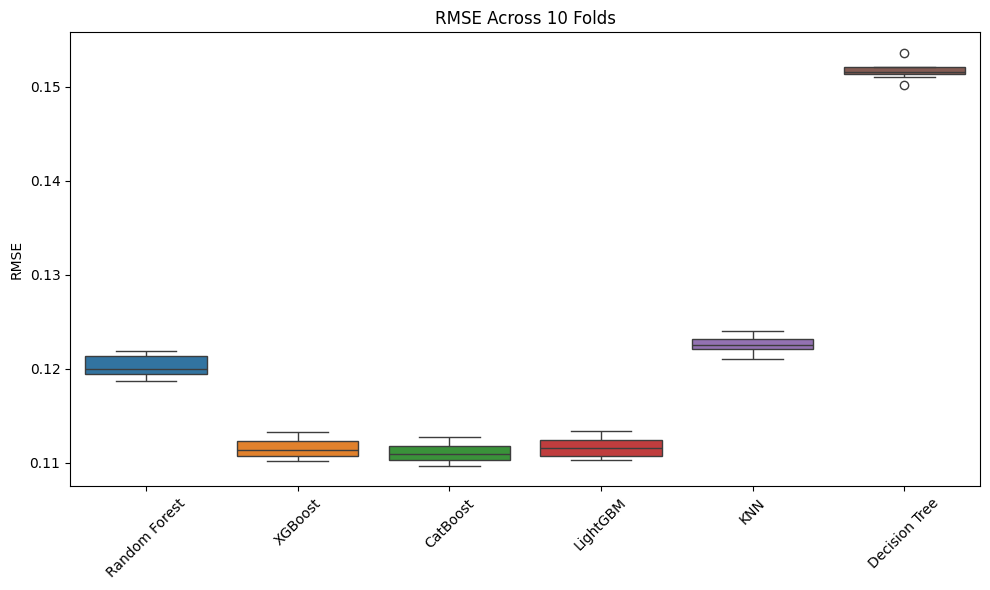

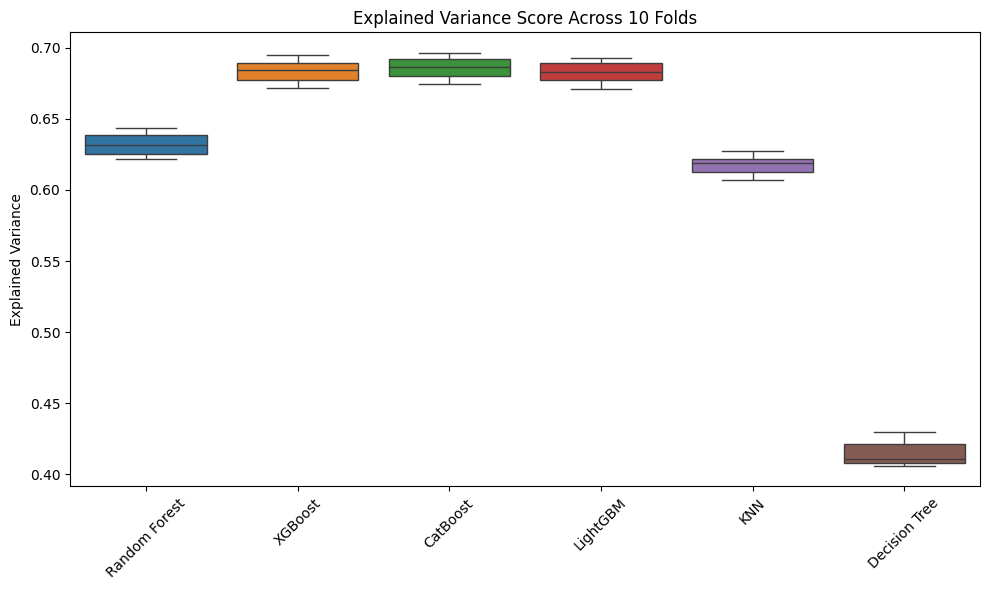


 Model Performance Summary:
           Model  Mean RMSE  Std RMSE  Mean Explained Var  Std Explained Var  \
0  Random Forest     0.1203    0.0011              0.6320             0.0079   
1        XGBoost     0.1115    0.0010              0.6839             0.0075   
2       CatBoost     0.1110    0.0010              0.6863             0.0072   
3       LightGBM     0.1116    0.0010              0.6831             0.0072   
4            KNN     0.1226    0.0008              0.6177             0.0062   
5  Decision Tree     0.1517    0.0008              0.4146             0.0079   

   Time Taken (s)  
0        732.7619  
1         13.0142  
2        270.5055  
3         23.6379  
4         41.1824  
5         11.1196  


In [ ]:
d1 = {}
d2 = {}
d3 = {'verbose' : 0}
d4 = { 'verbose' : 0, 'force_col_wise' : True}
d5 = {}
d6 = {}
compare_models(X, y, d1, d2, d3, d4, d5, d6)

### With Tuned hyper parameters

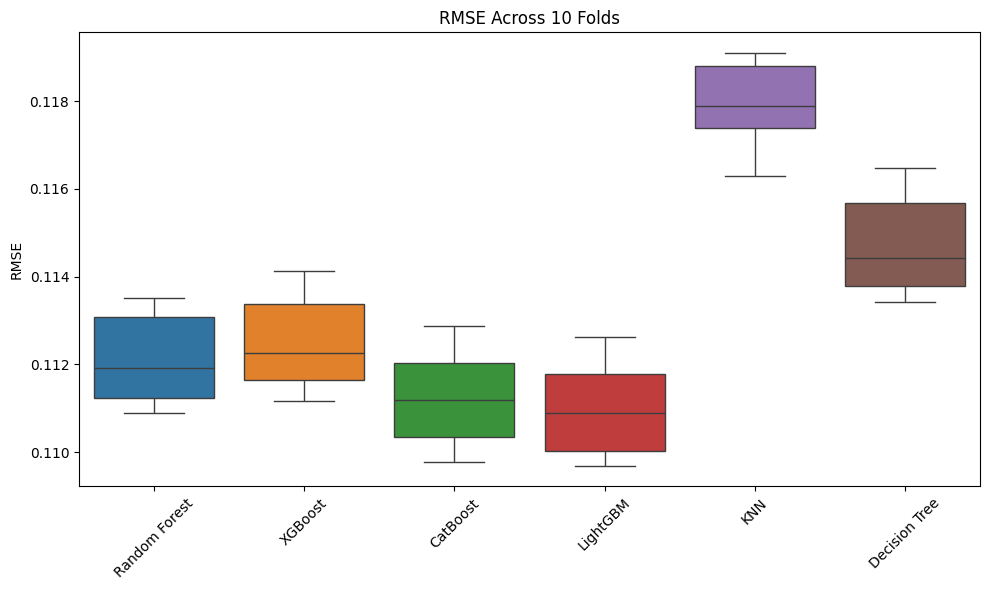

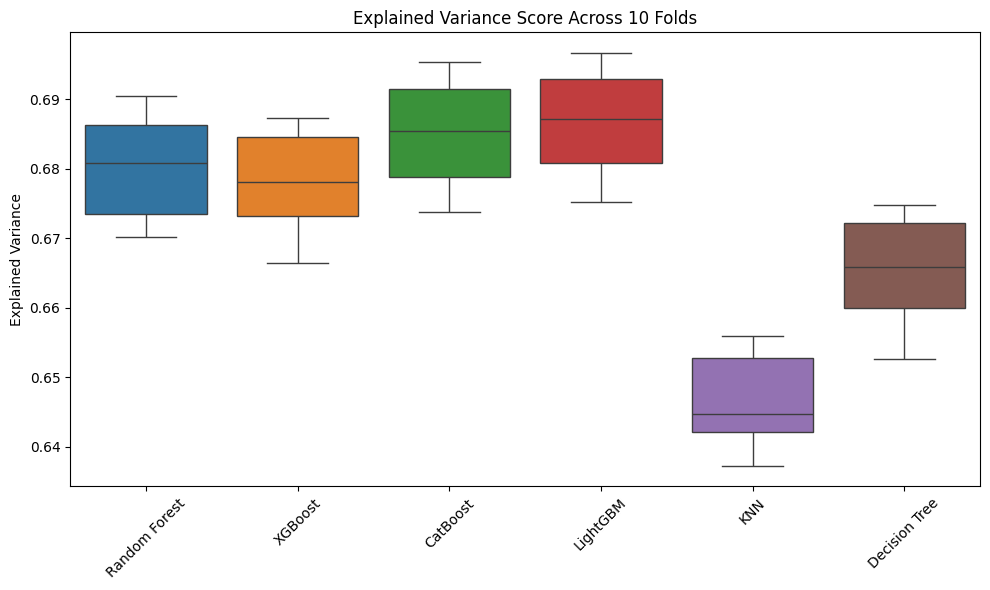


 Model Performance Summary:
           Model  Mean RMSE  Std RMSE  Mean Explained Var  Std Explained Var  \
0  Random Forest     0.1121    0.0010              0.6802             0.0072   
1        XGBoost     0.1125    0.0010              0.6782             0.0070   
2       CatBoost     0.1112    0.0010              0.6854             0.0072   
3       LightGBM     0.1110    0.0010              0.6868             0.0071   
4            KNN     0.1179    0.0009              0.6463             0.0064   
5  Decision Tree     0.1147    0.0010              0.6654             0.0074   

   Time Taken (s)  
0        394.2421  
1         67.2635  
2        137.1177  
3         51.4159  
4        545.7488  
5          4.9811  


In [ ]:
# BAYESIAN SEARCH

d1 = {'max_depth' : 20, 'max_features' : 'log2',  'min_samples_split' : 10,\
                         'n_estimators' : 200, 'random_state' : 42} # RANDOM FOREST BAYESIAN SEARCH
d2 = {'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 300, 'subsample': 0.8,'verbose' : -1}
d3 = {'border_count' : 254,'depth' : 6, 'iterations': 500, 'l2_leaf_reg' : 5, 'learning_rate' : 0.1,'verbose' : 0} ## CATBOOST - BAYSEIAN SEARCH
d4 = {'colsample_bytree':0.8, 'max_depth':10,\
      'n_estimators':300, 'num_leaves':50, 'subsample':0.8, 'verbose' : -1, 'force_col_wise' : True}
d5 = {'algorithm':'brute', 'leaf_size':50, 'n_neighbors': 11, 'p': 1,'weights' :'uniform'}
d6 = {'criterion':'squared_error', 'max_depth':10, 'min_samples_leaf':10,'min_samples_split':10}
compare_models(X, y, d1, d2, d3, d4, d5, d6)

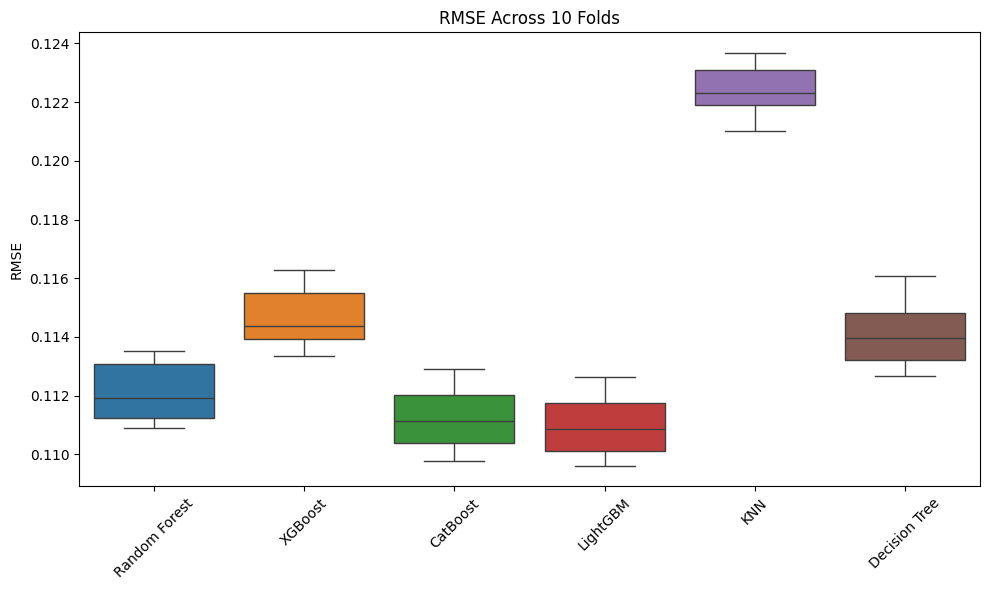

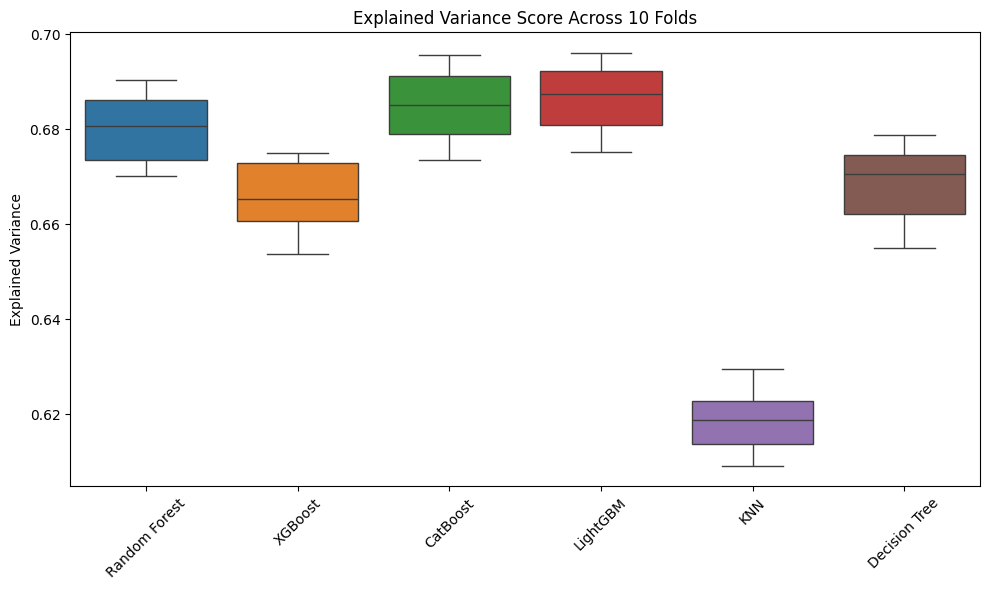


 Model Performance Summary:
           Model  Mean RMSE  Std RMSE  Mean Explained Var  Std Explained Var  \
0  Random Forest     0.1121    0.0010              0.6802             0.0072   
1        XGBoost     0.1146    0.0010              0.6658             0.0071   
2       CatBoost     0.1112    0.0010              0.6854             0.0073   
3       LightGBM     0.1110    0.0010              0.6867             0.0069   
4            KNN     0.1225    0.0008              0.6186             0.0061   
5  Decision Tree     0.1141    0.0010              0.6688             0.0076   

   Time Taken (s)  
0        400.4307  
1         41.5034  
2        137.4312  
3         60.9084  
4         48.2708  
5          5.1664  


In [ ]:
# Random SEARCH

d1 = {'max_depth' : 20, 'max_features' : 'log2',  'min_samples_split' : 10,\
                         'n_estimators' : 200, 'random_state' : 42} # RANDOM FOREST BAYESIAN SEARCH
d2 = {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8}
d3 = {'border_count' : 254,'depth' : 6, 'iterations': 500, 'l2_leaf_reg' : 1, 'learning_rate' : 0.1,'verbose' : 0} ## CATBOOST - BAYSEIAN SEARCH
d4 = {'colsample_bytree':0.8, 'learning_rate':0.05, 'max_depth':10,\
      'n_estimators':300, 'num_leaves':70,\
       'subsample':0.6, 'verbose' : -1, 'force_col_wise' : True}
d5 = {'weights': 'uniform', 'p': 1, 'n_neighbors': 5, 'leaf_size': 30, 'algorithm': 'auto'}
d6 = {'min_samples_split': 5, 'min_samples_leaf': 50, 'max_depth': None, 'criterion': 'squared_error'}
compare_models(X, y, d1, d2, d3, d4, d5, d6)

In [15]:
from     sklearn.model_selection  import     train_test_split
X_train, X_test, y_train, y_test =   train_test_split(X, y, test_size = 0.2, random_state = 42)

In [16]:
d4 = {'colsample_bytree':0.8, 'max_depth':10,\
      'n_estimators':300, 'num_leaves':50, 'subsample':0.8, 'verbose' : -1, 'force_col_wise' : True}

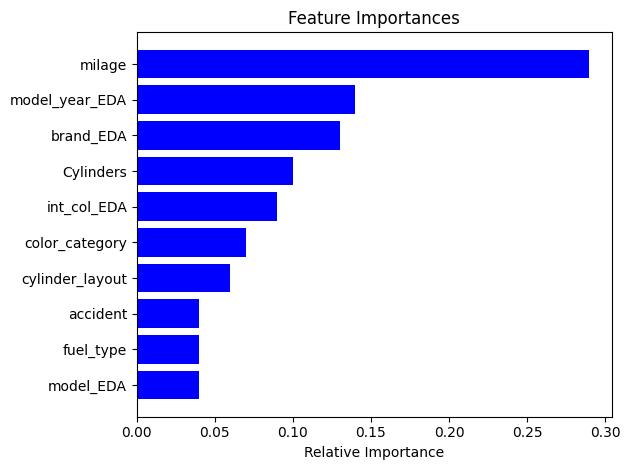

In [39]:
features                          =   X.columns
model_txt                         =   'LightGBM      - BayesSearchCV'
new_model                         =   LGBMRegressor()
new_model.set_params(**d4).fit(X_train, y_train)
feature_plot(new_model, model_txt, X, features)

In [37]:
import pandas as pd

# Assuming your trained model is named 'rf_model' and your feature names are in 'X_train.columns'
importances=[np.round(new_model.feature_importances_ /sum( new_model.feature_importances_),2) for i in new_model.feature_importances_ ][0]

feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance++': importances
})

# Optional: sort by importance for better readability
feature_importance_df = feature_importance_df.sort_values(by = 'Importance++', ascending = False).reset_index(drop = True)

note1    =    "\033[1;31mNote:\++ " + "It is the normalized score of the total impurity or variances reduction attributed to each feature over all trees" +\
              "\033[0m\033[0m\033[0m\033[0m"
print(feature_importance_df)
print(note1)

           Feature  Importance++
0           milage          0.29
1   model_year_EDA          0.14
2        brand_EDA          0.13
3        Cylinders          0.10
4      int_col_EDA          0.09
5   color_category          0.07
6  cylinder_layout          0.06
7        model_EDA          0.04
8        fuel_type          0.04
9         accident          0.04
Note:\++ It is the normalized score of the total impurity or variances reduction attributed to each feature over all trees


In [ ]:
Models_end_time                            =  time.time()
time_taken                                 =  Models_end_time - Models_start_time # time_taken is in seconds
hours, rest                                =  divmod(time_taken,3600)
minutes, seconds                           =  divmod(rest, 60)

In [ ]:
data = [["This application was processed using the PC with the below configuration", ":"],
        ["sklearn version", sklearn.__version__],
        ["Python version", python_version()],
        ["OS Name", os.name],
        ["System Platform", sys.platform],
        ["OS on which the Python interpreter is currently running", platform.system()],
        ['Platform Architecture',  str(platform.architecture())],
        ["\033[1;31mTotal RAM", str(round(psutil.virtual_memory().total/(1024 ** 3),0)) + ":GB" + "\033[0m\033[0m\033[0m\033[0m"],
        ["\033[1;31mTotal Execution time",  str(hours) + " Min: " + str(minutes) + " Seconds: " + str(round(seconds,6)) + "\033[0m\033[0m\033[0m\033[0m"]
       ]

headers = ["", "Values"]

print(tabulate(data, headers = headers, tablefmt = "grid"))

+--------------------------------------------------------------------------+----------------------------------+
|                                                                          | Values                           |
+==========================================================================+==================================+
| This application was processed using the PC with the below configuration | :                                |
+--------------------------------------------------------------------------+----------------------------------+
| sklearn version                                                          | 1.6.1                            |
+--------------------------------------------------------------------------+----------------------------------+
| Python version                                                           | 3.11.13                          |
+--------------------------------------------------------------------------+----------------------------